In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
e = st.norm()

In [3]:
def area_11(mu, delta):
    return (1-e.cdf(-mu-delta))**2

def area_00(mu,delta):
    return (e.cdf(-mu))**2

def star(mu,delta):
    return (e.cdf(-mu-delta) - e.cdf(-mu))**2

def corr_term_11(mu, delta):
    return (mu*(e.cdf(-mu-delta)-e.cdf(-mu))/delta + (e.pdf(-mu)-e.pdf(-mu-delta))/delta)**2

def corr_term_00(mu, delta):
    return ((mu+delta)*(e.cdf(-mu-delta)-e.cdf(-mu))/delta + (e.pdf(-mu)-e.pdf(-mu-delta))/delta)**2

def correct_ratio_11(mu,delta):
    return area_11(mu,delta)/(area_11(mu,delta)+corr_term_11(mu, delta))

def  correct_ratio_00(mu,delta):
    return area_00(mu,delta)/(area_00(mu,delta)+corr_term_00(mu, delta))

In [25]:
mus = np.linspace(-10,10,200)
deltas = np.linspace(-20,0,200)
X1, X2 = np.meshgrid(mus, deltas)
z1 = np.array([correct_ratio_00(mu, delta) for mu in mus for delta in deltas]).reshape(X1.shape)
z2 = np.array([correct_ratio_11(mu, delta) for mu in mus for delta in deltas]).reshape(X1.shape)

/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


/Users/susu/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


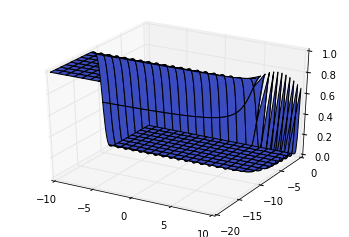

In [5]:
# correct_ratio_00
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, z1, cmap=cm.coolwarm)
plt.show()

/Users/susu/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


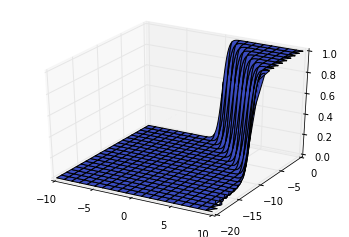

In [6]:
# correct_ratio_11
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, z2, cmap=cm.coolwarm)
plt.show()

# sample data

In [4]:
def mne(x, mu,delta,random, a):
    prob_x = 1 + (mu + x[1])/delta
    prob_y = 1 + (mu+x[0])/delta
    probs = np.cumsum([prob_x*prob_y, (1-prob_x)*prob_y, prob_x*(1-prob_y), (1-prob_x)*(1-prob_y)])
    prob = a.rvs(1, random_state = random)
    ind = np.searchsorted(probs, prob)
    if ind == 0:
        return [0,0,0]
    elif ind == 1:
        return [1,0,2]
    elif ind == 2:
        return [0,1,1]
    else:
        return [1,1,3]

def nash(x, true_mu, true_delta, random, a):
    if x[0] < -true_mu:
        if x[1] < -true_mu:
            return [0,0,0]
        else :
            return [0,1,1]
    elif -true_mu < x[0] < -true_mu -true_delta:
        if x[1] < -true_mu:
            return [1,0,2]
        elif -true_mu < x[1] < -true_mu -true_delta:
            return mne(x, true_mu,true_delta, random, a)
        else:
            return [0,1,1]
    else:
        if x[1] < -true_mu -true_delta:
            return [1,0,2]
        else:
            return [1,1,3]

In [23]:
# mixed strategyで結果を出すデータの生成
true_mu = 0.5
true_delta = -1
market_size = 10000

data = e.rvs(size = (market_size,2), random_state = 101)
a = st.uniform()
data2 = np.ones((market_size, 3))
for i in range(0,market_size):
    data2[i,:] = nash(data[i,:],true_mu, true_delta, i, a)
    
df = pd.DataFrame({"eps1" : data[:,0], "eps2" : data[:, 1], "ent1" : data2[:, 0], "ent2" : data2[:, 1], "equi" : data2[:, 2]})

## MLE

In [54]:
# MLE
def one(mu,delta):
    return e.pdf(mu+delta)**2 - e.cdf(mu+delta)*(mu+delta)*e.pdf(mu+delta)
    
def two(mu, delta):
    return (e.cdf(mu+delta)*e.pdf(mu+delta))**2

def three(mu,delta):
    return e.cdf(mu+delta)*e.pdf(mu+delta) - e.cdf(-mu)*e.pdf(mu)

def four(mu, delta):
    return e.cdf(mu+delta)*e.pdf(mu+delta)

def five(mu,delta):
    return e.pdf(mu)**2 + mu*e.cdf(-mu)*e.pdf(mu)

def six(mu,delta):
    return (e.cdf(-mu)*e.pdf(mu))**2

def g_1(mu,delta,m11,m00,m1):
    result = 2*m11*four(mu,delta)/area_11(mu,delta) -2*m00*e.cdf(-mu)*e.pdf(mu)/area_00(mu,delta) - 2*m1*three(mu,delta)/(1-area_00(mu,delta) -area_11(mu,delta))
    return result/market_size

def g_2(mu,delta,m11,m00,m1):
    result = 2*m11*four(mu,delta)/area_11(mu,delta) -2*m1*four(mu,delta)/(1-area_00(mu,delta) -area_11(mu,delta))
    return result/market_size

def g_11(mu,delta,m11,m00,m1):
    result =  2*m11*(one(mu,delta)*area_11(mu,delta) - 2*two(mu,delta))/((area_11(mu,delta))**2)-\
    2*m00*(-five(mu,delta)*area_00(mu,delta) + 2*six(mu,delta))/((area_00(mu,delta))**2)-\
    2*m1*((one(mu,delta)+five(mu,delta))*(1-area_00(mu,delta) - area_11(mu,delta)) + 2*three(mu,delta)**2)/((1 - area_00(mu,delta) - area_11(mu,delta))**2)
    return result/market_size

def g_12(mu,delta,m11,m00,m1):
    result = 2*m11*(one(mu,delta)*area_11(mu,delta)-2*two(mu,delta))/((area_11(mu,delta))**2)-\
    2*m1*(one(mu,delta)*(1-area_00(mu,delta)-area_11(mu,delta)) + 2*three(mu,delta)*four(mu,delta))/((1-area_00(mu,delta) -area_11(mu,delta))**2)
    return result/market_size

def g_22(mu,delta,m11,m00,m1):
    result = 2*m11*(one(mu,delta)*area_11(mu,delta)-2*two(mu,delta))/((area_11(mu,delta))**2)-\
    2*m1*(one(mu,delta)*(1-area_00(mu,delta) -area_11(mu,delta)) + 2*two(mu,delta))/((1-area_00(mu,delta) -area_11(mu,delta))**2)
    return result/market_size

def hess(mu,delta,m11,m00,m1):
    hessian = np.ones((2,2))
    hessian[0,0] = g_11(mu,delta,m11,m00,m1)
    hessian[0,1] = g_12(mu,delta,m11,m00,m1)
    hessian[1,0] = g_12(mu,delta,m11,m00,m1)
    hessian[1,1] = g_22(mu,delta,m11,m00,m1)
    return hessian

def grad(mu,delta,m11,m00,m1):
    gradient = np.ones((2,1))
    gradient[0,0] = g_1(mu,delta,m11,m00,m1)
    gradient[1,0] = g_2(mu,delta,m11,m00,m1)
    return gradient

def NR(theta, m11,m00,m1,maxit, tol):
    for i in range(0,maxit):
        #print(hess(theta[0,0],theta[1,0],m11,m00,m1))
        del_theta = np.linalg.inv(hess(theta[0,0],theta[1,0],m11,m00,m1)).dot(grad(theta[0,0],theta[1,0],m11,m00,m1))
        theta = theta - del_theta
        if np.linalg.norm(del_theta) < tol:
            print("NR終わり")
            break
    return theta

# mainで使うitrationを数回で終わらせるやつ
def NR1(theta, m11,m00,m1,itr, tol):
    for i in range(0,itr):
        del_theta = np.linalg.inv(hess(theta[0,0],theta[1,0],m11,m00,m1)).dot(grad(theta[0,0],theta[1,0],m11,m00,m1))
        theta = theta - del_theta
        #print(theta)
        if np.linalg.norm(del_theta) < tol:
            # print("NR終わり")
            break
    return theta

# まぁ制約の解がclosed form出かけるので一気にMLEしちゃえばいいんだけどね。（これは微分が複雑すぎてやだからしたの二重ループを考える）
def main(theta,m11,m00,m1,maxit,tol, itr):
    for j in range(0,maxit):
        ratio00 = correct_ratio_00(theta[0,0], theta[1,0])
        ratio11 = correct_ratio_11(theta[0,0], theta[1,0])
        #print(ratio11)
        newm00 = m00 * ratio00
        newm11 = m11 * ratio11
        newm1 = market_size - newm11 - newm00
        newtheta = NR1(theta,newm11,newm00,newm1,itr,tol)
        if np.linalg.norm(newtheta - theta) < tol:
            print("main終わり")
            break
        theta = newtheta
    return newtheta

# MLE元のやつ
def one(mu,delta):
    return e.pdf(mu+delta)**2 - e.cdf(mu+delta)*(mu+delta)*e.pdf(mu+delta)
    
def two(mu, delta):
    return (e.cdf(mu+delta)*e.pdf(mu+delta))**2

def three(mu,delta):
    return e.cdf(mu+delta)*e.pdf(mu+delta) - e.cdf(-mu)*e.pdf(mu)

def four(mu, delta):
    return e.cdf(mu+delta)*e.pdf(mu+delta)

def five(mu,delta):
    return e.pdf(mu)**2 + mu*e.cdf(-mu)*e.pdf(mu)

def six(mu,delta):
    return (e.cdf(-mu)*e.pdf(mu))**2

## MLEパーツ調整
def one(mu,delta):
    a = e.cdf(mu+delta)
    if a > 0.999994223227:
        return e.pdf(mu+delta)**2 - (mu+delta)*e.pdf(mu+delta)
    elif 1- 0.999994223227 > a:
        return e.pdf(mu+delta)**2
    else:
        return e.pdf(mu+delta)**2 - a*(mu+delta)*e.pdf(mu+delta)
    
def two(mu, delta):
    a = e.cdf(mu+delta)
    if a > 0.999994223227:
        return e.pdf(mu+delta)**2
    elif 1- 0.999994223227 > a:
        return 0
    else:
        return (a*e.pdf(mu+delta))**2

def three(mu,delta):
    a = e.cdf(-mu)
    b = e.cdf(mu+delta)
    if a > 0.999994223227:
        if b > 0.999994223227:
            return e.pdf(mu+delta) - e.pdf(mu)
        elif 1- 0.999994223227 > b:
            return - e.pdf(mu)
        else:
            return b*e.pdf(mu+delta) - e.pdf(mu)
    elif 1- 0.999994223227 > a:
        if b > 0.999994223227:
            return e.pdf(mu+delta)
        elif 1- 0.999994223227 > b:
            return 0
        else:
            return b*e.pdf(mu+delta)
    else:
        if b > 0.999994223227:
            return e.pdf(mu+delta) - a*e.pdf(mu)
        elif 1- 0.999994223227 > b:
            return - a*e.pdf(mu)
        else:
            return b*e.pdf(mu+delta) - a*e.pdf(mu)

def four(mu, delta):
    b = e.cdf(mu+delta)
    if b > 0.999994223227:
        return e.pdf(mu+delta)
    elif 1- 0.999994223227 > b:
        return 0
    else:
        return b*e.pdf(mu+delta)

def five(mu,delta):
    a = e.cdf(-mu)
    if a > 0.999994223227:
        return e.pdf(mu)**2 + mu*e.pdf(mu)
    elif 1- 0.999994223227 > a:
        return e.pdf(mu)**2
    else:
        return e.pdf(mu)**2 + mu*a*e.pdf(mu)

def six(mu,delta):
    a = e.cdf(-mu)
    if a > 0.999994223227:
        return (e.pdf(mu))**2
    elif 1- 0.999994223227 > a:
        return 0
    else:
        return (a*e.pdf(mu))**2

## main loop

これは片方の不動点しか考慮できてないので当然収束しない。正しい値からはずれないのも当然

true_mu = 0.5
true_delta = -1

In [55]:
maxit = 1000
tol = 1/maxit
itr = 1
initial = np.array([[0.5],[-1]])
m00 = sum([True for i in df["equi"] if i == 0.0])
m11 = sum([True for i in df["equi"] if i == 3.0])
m1 = market_size - m00 - m11

In [56]:
# 通常のbresnahan and reiss
# これだとバイアスが出る
initial = np.array([[0.5],[-1]])
NR(initial,m11,m00,m1,maxit,tol)

NR終わり


array([[ 0.3621809 ],
       [-0.73413157]])

In [61]:
# 正しいやつ入れれば確かに（そんなに）ずれない
itr = 10
maxit = 1000
initial = np.array([[0.5],[-1]])
main(initial,m11,m00,m1,maxit,tol, itr)

main終わり


array([[ 0.56303889],
       [-1.13845866]])

## mainが収束しないのでアルゴリズム変える

二つの不動点を同時に求める感じにする。

（ただし普通のMLEでも書けるのでそっちでもええよ）

true_mu = 0.5

true_delta = -1

In [25]:
def loop(theta,m11,m00,m1,tol, itr):
    # loop1-1
    ratio00 = correct_ratio_00(theta[0,0], theta[1,0])
    ratio11 = correct_ratio_11(theta[0,0], theta[1,0])
    newm00 = m00 * ratio00
    newm11 = m11 * ratio11
    newm1 = market_size - newm11 - newm00
    
    # loop2
    newtheta = NR1(theta,m11,m00,m1,itr,tol)
    newratio00 = correct_ratio_00(newtheta[0,0], newtheta[1,0])
    newratio11 = correct_ratio_11(newtheta[0,0], newtheta[1,0])
    newnewm00 = m00 * newratio00
    newnewm11 = m11 * newratio11
    newnewm1 = market_size - newnewm11 - newnewm00
    
    # loop1-2
    newnewtheta = NR1(newtheta,newm11,newm00,newm1,itr,tol)
    
    return newnewtheta, newnewm11, newnewm00, newnewm1

def main2(theta,m11,m00,m1,maxit,tol, itr):
    for i in range(1, maxit):
        newtheta,m11,m00,m1 = loop(theta,m11,m00,m1,tol, itr)
        print(newtheta)
        if np.linalg.norm(newtheta - theta) < tol:
            print("main2終わり")
            break
        theta = newtheta
    return newtheta

In [19]:
maxit = 1000
tol = 1/maxit
itr = 1000
initial = np.array([[0.5],[-1]])
m00 = sum([True for i in df["equi"] if i == 0.0])
m11 = sum([True for i in df["equi"] if i == 3.0])
m1 = market_size - m00 - m11

main2(initial,m11,m00,m1,maxit,tol, itr)

[[-0.09271262]
 [-1.62638631]]
[[-0.1199092 ]
 [-2.37095043]]
[[-0.12016587]
 [-3.40767735]]


/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
/Users/susu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [105]:
print(correct_ratio_00(0.5, -1))
print(correct_ratio_11(0.5, -1))

0.721979823602
0.721979823602
